<a href="https://colab.research.google.com/github/kanishkbehl/MARBLE-CRACK-IMAGE-DETECTION/blob/main/marble_crack_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task for Today  

***

# **Marble Crack Image Detection**  

Given *images of marble surfaces*, let's try to detect **cracks** in the marble.

We will use a TensorFlow CNN to make our predictions.

## **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

#**Creating Data Frames**

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [ ]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

## **Loading Image Data**

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)



In [ ]:
import pandas as pd

# Create a DataFrame for your single test image
test_df = pd.DataFrame({
    "Filepath": ["/kaggle/input/test-image-marble/tiles.png"],  # Update with your actual path
    "Label": ["unknown"]  # Dummy label (not used in prediction)
})

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode= None,
    batch_size=1,
    shuffle=False,
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1 validated image filenames.


# **Training**

In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33  

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 8s 69ms/step - loss: 0.6912 - accuracy: 0.5369 - val_loss: 0.6439 - val_accuracy: 0.8321
Epoch 2/100
105/105 [==============================] - 7s 67ms/step - loss: 0.6236 - accuracy: 0.7213 - val_loss: 0.5552 - val_accuracy: 0.7560
Epoch 3/100
105/105 [==============================] - 7s 68ms/step - loss: 0.5347 - accuracy: 0.7908 - val_loss: 0.4572 - val_accuracy: 0.8869
Epoch 4/100
105/105 [==============================] - 7s 67ms/step - loss: 0.4291 - accuracy: 0.8915 - val_loss: 0.3515 - val_accuracy: 0.8952
Epoch 5/100
105/105 [==============================] - 7s 70ms/step - loss: 0.3524 - accuracy: 0.9099 - val_loss: 0.2772 - val_accuracy: 0.9369
Epoch 6/100
105/105 [==============================] - 7s 71ms/step - loss: 0.2483 - accuracy: 0.9443 - val_loss: 0.2289 - val_accuracy: 0.9452
Epoch 7/100
105/105 [==============================] - 7s 68ms/step - loss: 0.2010 - accuracy: 0.9478 - val_loss: 0.1996 - val_accuracy:

# **Graphs**

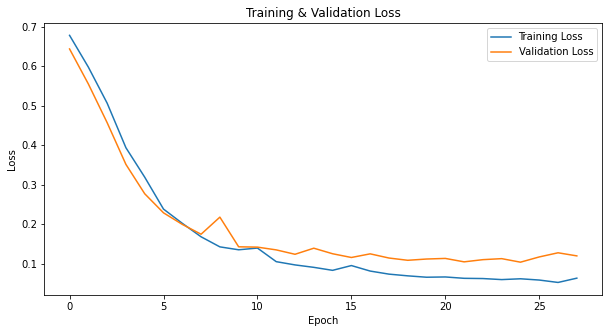

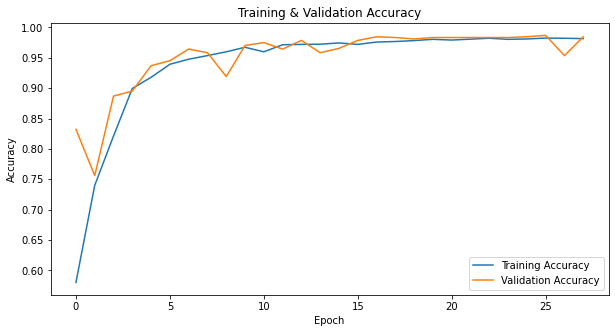

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# **Results**

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/kaggle/input/test-image-marble/tiles.png"  # Use your correct image path
img = image.load_img(img_path, target_size=(120, 120))  # Adjust target size to match your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize image

# Predict
prediction = model.predict(img_array)
print(f"Prediction Score: {prediction[0][0]}")  # If binary classification

# If your model predicts binary (0/1)
class_label = "Cracked" if prediction[0][0] > 0.5 else "Not Cracked"
print(f"Predicted Class: {class_label}")

Prediction Score: 0.9999986886978149
Predicted Class: Cracked
